In [53]:
!pip3 install polygon-api-client pandas requests matplotlib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [54]:
import pandas as pd
import requests
from polygon import RESTClient
import matplotlib.pyplot as plt

In [55]:
#Polygon API
api_key = "api-key"
client = RESTClient(api_key)

In [56]:
# Get Data
def data(ticker='C:EURUSD', timespan='minute', from_date='2023-01-01', to_date='2024-01-01', limit=50000):
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/{timespan}/{from_date}/{to_date}?adjusted=true&sort=asc&limit={limit}&apiKey={api_key}"
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"API request failed with status code {response.status_code}: {response.text}")
    
    data = response.json()
    df = pd.DataFrame(data['results'])
    df['timestamp'] = pd.to_datetime(df['t'], unit='ms')
    df.rename(columns={'o': 'Open', 'h': 'High', 'l': 'Low', 'c': 'Close', 'v': 'Volume'}, inplace=True)
    df.drop(columns=['vw', 'n', 't'], inplace=True)
    return df

data = data()
data

,Volume,Open,Close,High,Low,timestamp
0,1,1.06849,1.06849,1.06849,1.06849,2023-01-01 18:21:00
1,1,1.06839,1.06839,1.06839,1.06839,2023-01-01 18:46:00
2,1,1.06799,1.06799,1.06799,1.06799,2023-01-01 19:11:00
3,1,1.06789,1.06789,1.06789,1.06789,2023-01-01 19:36:00
4,1,1.06789,1.06789,1.06789,1.06789,2023-01-01 20:27:00
...,...,...,...,...,...,...
49995,20,1.06940,1.06950,1.06961,1.06940,2023-02-17 21:08:00
49996,39,1.06940,1.06954,1.06960,1.06940,2023-02-17 21:09:00
49997,33,1.06956,1.06940,1.06960,1.06940,2023-02-17 21:10:00
49998,38,1.06953,1.06945,1.06960,1.06930,2023-02-17 21:11:00


In [57]:
# Create signals
def signals(df, window=20, num_std=2):
    df['SMA'] = df['Close'].rolling(window).mean()
    df['STD'] = df['Close'].rolling(window).std()

    df['Upper Band'] = df['SMA'] + (df['STD'] * num_std)
    df['Lower Band'] = df['SMA'] - (df['STD'] * num_std)

    df['Buy Signal'] = (df['Close'] < df['Lower Band'])   
    df['Sell Signal'] = (df['Close'] > df['Upper Band']) 

    return df

data_w_signals = signals(data)
data_w_signals

,Volume,Open,Close,High,Low,timestamp,SMA,STD,Upper Band,Lower Band,Buy Signal,Sell Signal
0,1,1.06849,1.06849,1.06849,1.06849,2023-01-01 18:21:00,NaN,NaN,NaN,NaN,False,False
1,1,1.06839,1.06839,1.06839,1.06839,2023-01-01 18:46:00,NaN,NaN,NaN,NaN,False,False
2,1,1.06799,1.06799,1.06799,1.06799,2023-01-01 19:11:00,NaN,NaN,NaN,NaN,False,False
3,1,1.06789,1.06789,1.06789,1.06789,2023-01-01 19:36:00,NaN,NaN,NaN,NaN,False,False
4,1,1.06789,1.06789,1.06789,1.06789,2023-01-01 20:27:00,NaN,NaN,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,20,1.06940,1.06950,1.06961,1.06940,2023-02-17 21:08:00,1.069546,0.000105,1.069755,1.069336,False,False
49996,39,1.06940,1.06954,1.06960,1.06940,2023-02-17 21:09:00,1.069550,0.000102,1.069754,1.069346,False,False
49997,33,1.06956,1.06940,1.06960,1.06940,2023-02-17 21:10:00,1.069543,0.000108,1.069758,1.069327,False,False
49998,38,1.06953,1.06945,1.06960,1.06930,2023-02-17 21:11:00,1.069538,0.000110,1.069757,1.069319,False,False


In [58]:
def backtest(df, initial_balance=10000):
    position = 0
    entry_price = 0
    realized_gains = 0
    trades = []

    for i in range(1, len(df)):
        trade_data = {}

        if df['Buy Signal'][i] and position != 1:
            trade_data['Time'] = df['timestamp'][i]
            trade_data['Price'] = df['Close'][i]
            trade_data['Position'] = 1
            if(position == -1):
                profit = entry_price - df['Close'][i]
                trade_data['Profit'] = profit
                realized_gains += profit
                trade_data['Realized'] = realized_gains
                if(profit > 0):
                    trade_data['Result'] = "Win"
                else:
                    trade_data['Result'] = "Loss"
            else:
                trade_data['Realized'] = 0
            trade_data['Balance'] = initial_balance + realized_gains
            trades.append(trade_data)
            position = 1
            entry_price = df['Close'][i]

        elif df['Sell Signal'][i] and position != -1:
            trade_data['Time'] = df['timestamp'][i]
            trade_data['Price'] = df['Close'][i]
            trade_data['Position'] = -1
            if(position == 1):
                profit = df['Close'][i] - entry_price
                trade_data['Profit'] = profit
                realized_gains += profit
                trade_data['Realized'] = realized_gains
                if(profit > 0):
                    trade_data['Result'] = "Win"
                else:
                    trade_data['Result'] = "Loss"
            else:
                trade_data['Realized'] = 0
            trade_data['Balance'] = initial_balance + realized_gains
            trades.append(trade_data)
            position = -1
            entry_price = df['Close'][i]

    trade_df = pd.DataFrame(trades)

    return trade_df

backtest_results = backtest(data_w_signals)
backtest_results

,Time,Price,Position,Realized,Balance,Profit,Result
0,2023-01-02 00:47:00,1.07030,-1,0.00000,10000.00000,NaN,NaN
1,2023-01-02 01:17:00,1.07020,1,0.00010,10000.00010,0.00010,Win
2,2023-01-02 03:42:00,1.07023,-1,0.00013,10000.00013,0.00003,Win
3,2023-01-02 04:31:00,1.06972,1,0.00064,10000.00064,0.00051,Win
4,2023-01-02 05:51:00,1.06990,-1,0.00082,10000.00082,0.00018,Win
...,...,...,...,...,...,...,...
1092,2023-02-17 16:36:00,1.06677,-1,0.19507,10000.19507,0.00085,Win
1093,2023-02-17 17:48:00,1.06870,1,0.19314,10000.19314,-0.00193,Loss
1094,2023-02-17 18:46:00,1.06903,-1,0.19347,10000.19347,0.00033,Win
1095,2023-02-17 20:19:00,1.06930,1,0.19320,10000.19320,-0.00027,Loss


In [59]:
def analysis(trade_df, initial_balance=10000):
    num_trades = len(trade_df)
    winrate = ((trade_df['Result'] == "Win").sum() / num_trades) * 100
    final_balance = trade_df['Balance'].tail(1).values[0]
    net_returns = final_balance - initial_balance
    percent_return = (final_balance / initial_balance)
    avg_profit_per_trade = net_returns / num_trades
    largest_win = trade_df['Profit'].max()
    largest_loss = trade_df['Profit'].min()
    print(f'Winrate: {winrate}%')
    print(f'Final Balance: {final_balance}')
    print(f'Net Returns: {net_returns}')
    print(f'Percentage Returns: {percent_return}%')
    print(f'Total Trades: {num_trades}')
    print(f'Average Profit per Trade: {avg_profit_per_trade}')
    print(f'Largest Win: {largest_win}')
    print(f'Largest Loss: {largest_loss}')

analysis(backtest_results)

Winrate: 70.37374658158613%
Final Balance: 10000.19363
Net Returns: 0.19362999999975727
Percentage Returns: 1.000019363%
Total Trades: 1097
Average Profit per Trade: 0.0001765086599815472
Largest Win: 0.005709999999999882
Largest Loss: -0.009500000000000064


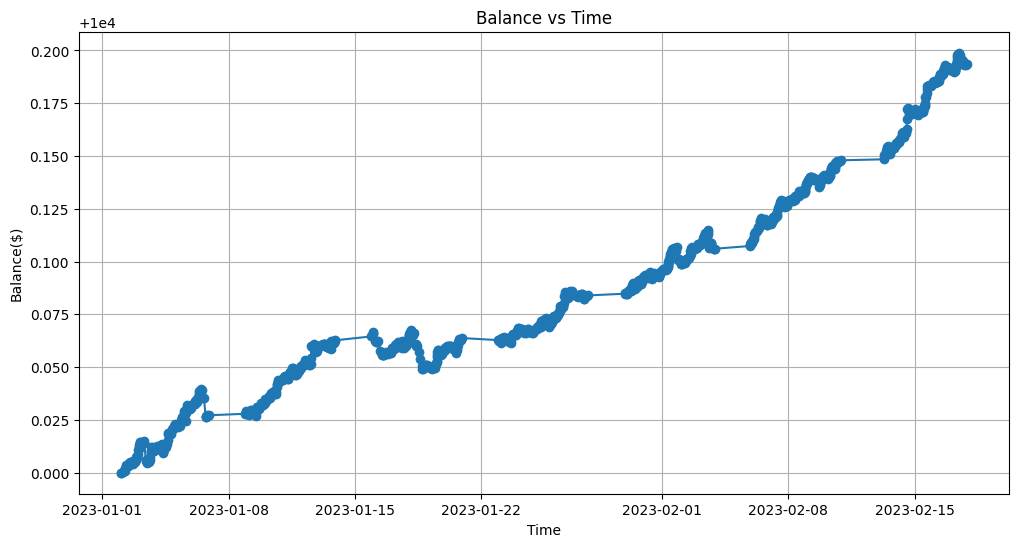

In [60]:
def plots(trade_df):
    plt.figure(figsize=(12, 6))
    plt.plot(trade_df['Time'], trade_df['Balance'], marker='o', linestyle='-')
    plt.title("Balance vs Time")
    plt.xlabel("Time")
    plt.ylabel("Balance($)")
    plt.grid()
    plt.show()

plots(backtest_results)